# Setting up Paths

In [1]:
#path to the data
pathCOMPASOutput = '/home/cneijssel/Documents/Projects/Data/CosmicInt/'
#path to compasrepo which contains ther popsynth folder
pathRepo = '/home/cneijssel/Documents/COMPASpop'



# Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py as h5
import time
import sys
import copy
#Quick fudge to make import from ../Scripts work
import sys
sys.path.append(pathRepo + '/popsynth/Papers/NeijsselEtAL/CosmicIntegration/Scripts')


# Custom Imports from COMPASrepo

In [3]:
import ClassCosmicIntegrator  as CI #Given settings and redshifts returns rates (2D arrays) Loads the data
import coencodeVarious as CV



# The cosmic integrator class

In [4]:
#Will only look at BBHs so might as well set everything
Data      = CI.CosmicIntegrator(COMPASpath = pathCOMPASOutput, DCOtypes='BBH')
Data.MSSFR.Zprescription         = 'logNormal'
Data.MSSFR.SFRprescription       = 'Neijssel et al. (2019)' 
Data.MSSFR.logNormalPrescription = 'Neijssel Phenomenological'


Remember to  self.setCOMPASDCOmask() and self.setCOMPASData()


In [5]:
#Sneaky fudge I only want to calculate at z=0.0, z=0.5, and z=1.
#Because no matter how you space it in linspace the centrer of the bin is never at zero.
#unless you do a hughe amount of shells (waste of energy, save the environment :p)
#I do not care if the shell volumes etc are correct since I do not use them
#I do set them so the inbuilt multiplications do not crash
Data.nrRedshiftBins           = 3
Data.Shell_centerRedshift     = np.array([0., 1.5, 3.])
Data.Shell_volume             = np.ones(len(Data.Shell_centerRedshift))
Data.Shell_dz                 = np.diff(Data.Shell_centerRedshift)
Data.Shell_luminosityDistance = np.ones(len(Data.Shell_centerRedshift))

# I do have to reset the 2D arrays
Data.setBirthTimesAnd2Darrays()
Data.cosmologicalIntegration()

The detected rate of the outermost redshift shell is nonzero, did we integrate far enough?


# The LIGO mass prior O1

In [6]:
#aLIGO assumption
sampleSize = 1000000
#min mass = log10(2.5), max mass =log10(100) from plot


#The testing and derivations of inverse power law CDFs can be found in additional
#Notebooks (see total mass evolved etc, in DCO_population)
minBHmass = 2.5
maxBHmass = 100

M1flat = 10**(np.random.uniform(np.log10(minBHmass), np.log10(maxBHmass), sampleSize))
M2flat = 10**(np.random.uniform(np.log10(minBHmass), np.log10(maxBHmass), sampleSize))
MtotalFlat = M1flat+M2flat


def inverseCDF(C, CDF, index, xmin, xmax):
    a =  (1./(index + 1)) * C * CDF**(index+1)
    b =  (1./(index + 1)) * C * xmin**(index+1)
    c =  (1./(index + 1)) * C * xmax**(index+1)
    top    = ((CDF * (c-b))+b)*(index + 1)
    bottom = C
    return (top/bottom)**(1./(index+1))
M1powerlaw = np.random.uniform(0.0, 1., sampleSize)
M1powerlaw = inverseCDF(1., M1powerlaw, -2.35, minBHmass, maxBHmass)
M2flatq    = np.random.uniform(0.0, 1., sampleSize)
M2powerlaw = np.multiply(M1powerlaw, M2flatq)
mask       = M2powerlaw >2.5
MtotalPower= M1powerlaw[mask] + M2powerlaw[mask]

# The plot

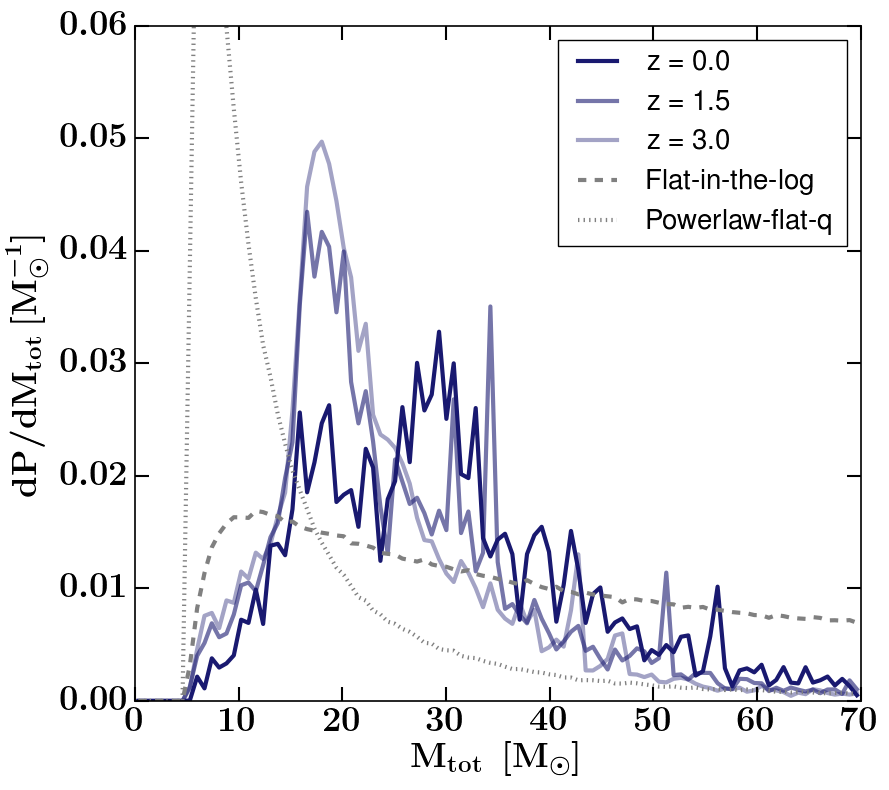

In [7]:
massBins  = np.linspace(0,70, 100)
mass      = (massBins[1:]+massBins[:-1])/2.
dM        = np.diff(massBins)

#consistency through paper
colourBBH = 'midnightblue'
#shade per redshift
alpha     = [1., 0.6, 0.4]

#Total masses COMPAS per system
Mtotal    = Data.COMPAS.mass1 + Data.COMPAS.mass2
Redshifts = Data.Shell_centerRedshift
#each row in the 2D array is the rate per system at a redshift center at shell above
#Hence the rate per system acts as a weight per system for the binning below

fig, axes = plt.subplots(1,1, figsize=(9,8))
for nrR, Row in enumerate(Data.PerSystemPerRedshift_ratesIntrinsic):
    rate, bins = np.histogram(Mtotal, bins=massBins, weights=Row)
    rate       = np.divide(rate, dM)
    rate       = rate/float(np.sum(rate))
    axes.plot(mass, rate, lw=3., c=colourBBH, alpha=alpha[nrR], label='z = %s' %Redshifts[nrR])

#Additonally plot two total mass distributions from LIGO
rate, bins = np.histogram(MtotalFlat, bins=massBins)
rate       = np.divide(rate, dM)
rate       = rate/float(np.sum(rate))
axes.plot(mass, rate, lw=3., c='grey', linestyle='--', label='Flat-in-the-log')
rate, bins = np.histogram(MtotalPower, bins=massBins)
rate       = np.divide(rate, dM)
rate       = rate/float(np.sum(rate))
axes.plot(mass, rate, lw=3., c='grey', linestyle=':', label='Powerlaw-flat-q')



nameX = r'$\rm M_{tot}\ \ [M_{\odot}] $'
nameY = r'$\rm dP/dM_{tot} \ [M_{\odot}^{-1}]  $'
axes = CV.layoutAxes(axes, nameX=nameX, nameY=nameY)
axes.legend(loc=1, prop={'size':20})
axes.set_ylim(top=0.06)
plt.tight_layout()
plt.savefig('./MassDistributionAtRedshift.png', dpi=300, transparent=False)
plt.show()
plt.close()

The detected rate of the outermost redshift shell is nonzero, did we integrate far enough?
The detected rate of the outermost redshift shell is nonzero, did we integrate far enough?
The detected rate of the outermost redshift shell is nonzero, did we integrate far enough?
The detected rate of the outermost redshift shell is nonzero, did we integrate far enough?


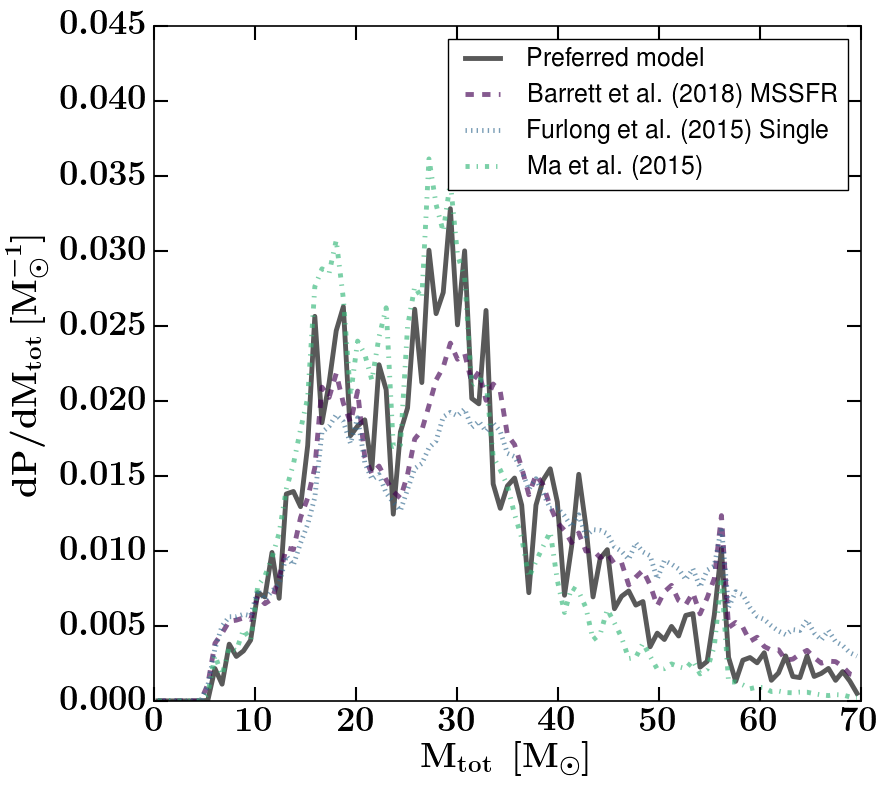

In [8]:
#The distribution of DCOs as a function of redshift

method     = ['logNormal'                ,'MZ_GSMF'                     ,'MZ_GSMF'                      , 'MZ_GSMF']
SFRs       = ['Neijssel et al. (2019)'   ,'Madau et al. (2014)'         ,'Madau et al. (2014)'          , 'Madau et al. (2014)']
logNormal  = ['Neijssel Phenomenological', None                         , None                          , None]
GSMFs      = [None                       , 'Panter et al. (2004) Single', 'Furlong et al. (2015) Single', 'Panter et al. (2004) Single']
MZs        = [None                       , 'Langer et al. (2006)'       , 'Langer et al. (2006)'        , 'Ma et al. (2015)']

linestyles = ['-'                        , '--'                         , ':'                           , '-.']
labels     = ['Preferred model'          , 'Barrett et al. (2018) MSSFR', 'Furlong et al. (2015) Single', 'Ma et al. (2015)']


cm       = plt.get_cmap('viridis')
nColors  = 3+1  #want three colours for three variations (1 used in other plot later)
                    # dont want the brigthest colour hence I add a dummy value.
                    #Should be consistent with figure of metallicity PDFs
mycolors = [cm(x) for x in np.linspace(0,1 , nColors)]

colours  =  [ 'k'                        ,mycolors[0]                   , mycolors[1]                   , mycolors[2]]


fig, axes = plt.subplots(1,1, figsize=(9,8))

for nrL, L in enumerate(labels):
    Data.MSSFR.Zprescription         = method[nrL]
    Data.MSSFR.SFRprescription       = SFRs[nrL]
    Data.MSSFR.logNormalPrescription = logNormal[nrL]
    Data.MSSFR.GSMFprescription      = GSMFs[nrL]
    Data.MSSFR.ZMprescription        = MZs[nrL]
    Data.cosmologicalIntegration()
        
    
    Row        = Data.PerSystemPerRedshift_ratesIntrinsic[0]
    #Additonally plot two total mass distributions from LIGO
    rate, bins = np.histogram(Mtotal, bins=massBins, weights=Row)
    rate       = np.divide(rate, dM)
    rate       = rate/float(np.sum(rate))
    axes.plot(mass, rate, lw=3.5, c=colours[nrL], label=labels[nrL], linestyle=linestyles[nrL], alpha=0.65)

   
nameX = r'$\rm M_{tot}\ \ [M_{\odot}] $'
nameY = r'$\rm dP/dM_{tot} \ [M_{\odot}^{-1}]  $'
axes = CV.layoutAxes(axes, nameX=nameX, nameY=nameY)
axes.legend(loc=1, prop={'size':18})
axes.set_ylim(top=0.045)
plt.tight_layout()
plt.savefig('./MassDistributionAtRedshift0.png', dpi=300, transparent=False)
plt.show()
plt.close()

In [9]:
#Double checking the peak at 30 Msun, what redshifts due they come from
#For clarity I want fraction. 
Data.MSSFR.Zprescription         = 'MZ_GSMF'
Data.MSSFR.GSMFprescription      = variations[2][0]
Data.MSSFR.ZMprescription        = variations[2][1]
Data.MSSFR.SFRprescription       = variations[2][2]
Data.cosmologicalIntegration()

NameError: name 'variations' is not defined

In [ ]:
rate   = Data.PerSystemPerRedshift_ratesIntrinsic[0]
birthz = Data.PerSystemPerRedshift_redshiftBirth[0]

bins   = np.linspace(0,10, 11)
center = (bins[1:]+bins[:-1])/2.
print center

In [ ]:
cm = plt.get_cmap('viridis')
nColors = len(center)+1  #dont want brightest colour so offset by one
colours = [cm(x) for x in np.linspace(0,1 , nColors)] 

Array2D = np.zeros(shape=(len(center), len(mass)))
#Instead of directly fill between plot I fill in array so I can normalize per bin later
                   
for nrz, zbirth in enumerate(center):
    maskz = (birthz>=bins[nrz]) & (birthz < bins[nrz+1])
    hist, bins = np.histogram(Mtotal[maskz], bins=massBins, weights=rate[maskz])
    Array2D[nrz] = hist

#normalize each mass bin (column) by total rate in column
normalization = np.sum(Array2D, axis=0)
fig, axes = plt.subplots(1,1, figsize=(9,8))

lowerY = np.zeros(len(mass))
for nrr, row in enumerate(Array2D):
    row    = np.divide(row, normalization)
    upperY = lowerY + row
    axes.fill_between(mass, lowerY, upperY, facecolor=colours[nrr], label='z=%s'%center[nrr])
    lowerY = upperY
nameX = r'$\rm redshift $'
nameY = r'$\rm fraction  $'
axes = CV.layoutAxes(axes, nameX=nameX, nameY=nameY)
axes.legend(loc=1, prop={'size':10})
plt.tight_layout()
plt.show()
plt.close()